In [ ]:
import gc
import joblib
import sys
import pathlib
import yaml
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, MeanAbsoluteError

## Metadata Column Definition

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

## Obtain repository root directory for access to preprocessed data, config file and local package

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

### Import packages

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.append(str(REPO_ROOT))
sys.path.append(str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from analysis_utils.buddi4data import BuDDI4Data
from buddi_v2.dataset.buddi4_dataset import get_supervised_dataset, get_unsupervised_dataset
from buddi_v2.models.buddi4 import fit_buddi4
from buddi_v2.models.components.losses import unsupervised_dummy_loss_fn
from buddi_v2.models.buddi4_class import BuDDI4
from buddi_v2.plotting.plot_latent_space import plot_latent_spaces_buddi4
from buddi_v2.plotting.plot_data import plot_data

I0000 00:00:1746135824.823866 1555183 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4263 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


## Define paths to Input Files/Output

### Input from pre-processing

In [5]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data' 
train_data_file = PREPROCESSING_OUTPUT_PATH / 'buddi4_train_data.pkl'
assert train_data_file.exists(), f"Train data file not found at {train_data_file}"

### Model weight output saved to...

In [6]:
TRAINED_MODELS_PATH = REPO_ROOT / 'trained'
TRAINED_MODELS_PATH.mkdir(exist_ok=True)
TRAIN_PLOT_PATH = TRAINED_MODELS_PATH / 'train_plots'
TRAIN_PLOT_PATH.mkdir(exist_ok=True)

## Training

### Load train data

In [7]:
train_data = joblib.load(train_data_file)
print(train_data)
print('\n')

n_x = len(train_data.gene_names)
n_y = len(train_data.cell_type_names)
n_labels = train_data.encode_meta[SAMPLE_ID_COL].shape[1]
n_stims = train_data.encode_meta[STIM_COL].shape[1]
n_samp_types = train_data.encode_meta[TECH_COL].shape[1]
print(f"Number of genes: {n_x}")
print(f"Number of cell types: {n_y}")
print(f"Number of unique labels: {n_labels}")
print(f"Number of unique stimulations: {n_stims}")
print(f"Number of unique sample types: {n_samp_types}")

BuDDIData(unkp_samples=588, kp_samples=8400, genes=7000, cell_types=11)


Number of genes: 7000
Number of cell types: 11
Number of unique labels: 593
Number of unique stimulations: 2
Number of unique sample types: 2


### Convert data to tensorflow dataset

In [8]:
ds_sup = get_supervised_dataset(
    X_known_prop=train_data.get(condition='kp', key='X'),
    Y_known_prop=train_data.get(condition='kp', key='Y'),
    label_known_prop=train_data.get(condition='kp', key='label'),
    stim_known_prop=train_data.get(condition='kp', key='stim'),
    samp_type_known_prop=train_data.get(condition='kp', key='samp_type'),
)
print(f"Number of entries in supervised dataset: {ds_sup.cardinality().numpy()}")
ds_sup_batch_x, ds_sup_batch_y = next(iter(ds_sup))

ds_unsup = get_unsupervised_dataset(
    X_unknown_prop=train_data.get(condition='unkp', key='X'),
    label_unknown_prop=train_data.get(condition='unkp', key='label'),
    stim_unknown_prop=train_data.get(condition='unkp', key='stim'),
    samp_type_unknown_prop=train_data.get(condition='unkp', key='samp_type'),
)
print(f"Number of entries in unsupervised dataset: {ds_unsup.cardinality().numpy()}")

print("\nTake a peek at the dataset generator return:\n")

ds_sup_batch_input, ds_sup_batch_target = next(iter(ds_sup.batch(16).take(1)))
ds_sup_batch_x, ds_sup_batch_y = ds_sup_batch_input
print(f"Supervised batch x shape: {ds_sup_batch_x.shape}")
print(f"Supervised batch y shape: {ds_sup_batch_y.shape}")
ds_sup_batch_target_x, _, _, _, _, ds_sup_batch_label, ds_sup_batch_stim, ds_sup_batch_samp_type, ds_sup_batch_target_y = ds_sup_batch_target
print(f"Supervised batch target x shape: {ds_sup_batch_target_x.shape}")
print(f"Supervised batch target y shape: {ds_sup_batch_target_y.shape}")
print(f"Supervised batch label shape: {ds_sup_batch_label.shape}")
print(f"Supervised batch stim shape: {ds_sup_batch_stim.shape}")
print(f"Supervised batch samp_type shape: {ds_sup_batch_samp_type.shape}")

print("\n")

ds_unsup_batch_input, ds_unsup_batch_target = next(iter(ds_unsup.batch(16).take(1)))
ds_unsup_batch_x, = ds_unsup_batch_input
print(f"Unsupervised batch x shape: {ds_unsup_batch_x.shape}")
ds_unsup_batch_target_x, _, _, _, _, ds_unsup_batch_label, ds_unsup_batch_stim, ds_unsup_batch_samp_type, _ = ds_unsup_batch_target
print(f"Unsupervised batch target x shape: {ds_unsup_batch_target_x.shape}")
print(f"Unsupervised batch label shape: {ds_unsup_batch_label.shape}")
print(f"Unsupervised batch stim shape: {ds_unsup_batch_stim.shape}")
print(f"Unsupervised batch samp_type shape: {ds_unsup_batch_samp_type.shape}")

Number of entries in supervised dataset: 8400
Number of entries in unsupervised dataset: 588

Take a peek at the dataset generator return:

Supervised batch x shape: (16, 7000)
Supervised batch y shape: (16, 11)
Supervised batch target x shape: (16, 7000)
Supervised batch target y shape: (16, 11)
Supervised batch label shape: (16, 593)
Supervised batch stim shape: (16, 2)
Supervised batch samp_type shape: (16, 2)


Unsupervised batch x shape: (16, 7000)
Unsupervised batch target x shape: (16, 7000)
Unsupervised batch label shape: (16, 593)
Unsupervised batch stim shape: (16, 2)
Unsupervised batch samp_type shape: (16, 2)


In [ ]:
RECONST_ALPHA = 1.0
CLS_ALPHA = 100.0
Y_ALPHA = 100.0
BETA = 100.0
BETA_SLACK = 1000.0

obj = BuDDI4(
    n_x=n_x,
    n_y=n_y,
    n_labels=n_labels,
    n_stims=n_stims,
    n_samp_types=n_samp_types,
    z_dim=64,
    encoder_hidden_dim=512,
    decoder_hidden_dim=512,
    activation='relu',
    output_activation='sigmoid',
)

obj.set_reconstruction_loss(
    fn=MeanAbsoluteError(),
    weight=RECONST_ALPHA,
)
obj.set_encoder_loss(
    branch='label',
    fn=unsupervised_dummy_loss_fn,
    weight=BETA,    
)
obj.set_encoder_loss(
    branch='stim',
    fn=unsupervised_dummy_loss_fn,
    weight=BETA,    
)
obj.set_encoder_loss(
    branch='samp_type',
    fn=unsupervised_dummy_loss_fn,
    weight=BETA,    
)
obj.set_encoder_loss(
    branch='slack',
    fn=unsupervised_dummy_loss_fn,
    weight=BETA_SLACK,    
)
obj.set_predictor_loss(
    branch='label',
    fn=CategoricalCrossentropy,
    weight=CLS_ALPHA
)
obj.set_predictor_loss(
    branch='stim',
    fn=CategoricalCrossentropy,
    weight=CLS_ALPHA
)
obj.set_predictor_loss(
    branch='samp_type',
    fn=CategoricalCrossentropy,
    weight=CLS_ALPHA
)
obj.set_prop_estimator_loss(
    fn=MeanAbsoluteError,
    weight=Y_ALPHA,
)

obj.compile(optimizer=Adam(learning_rate=0.0005))

### Visualize connection

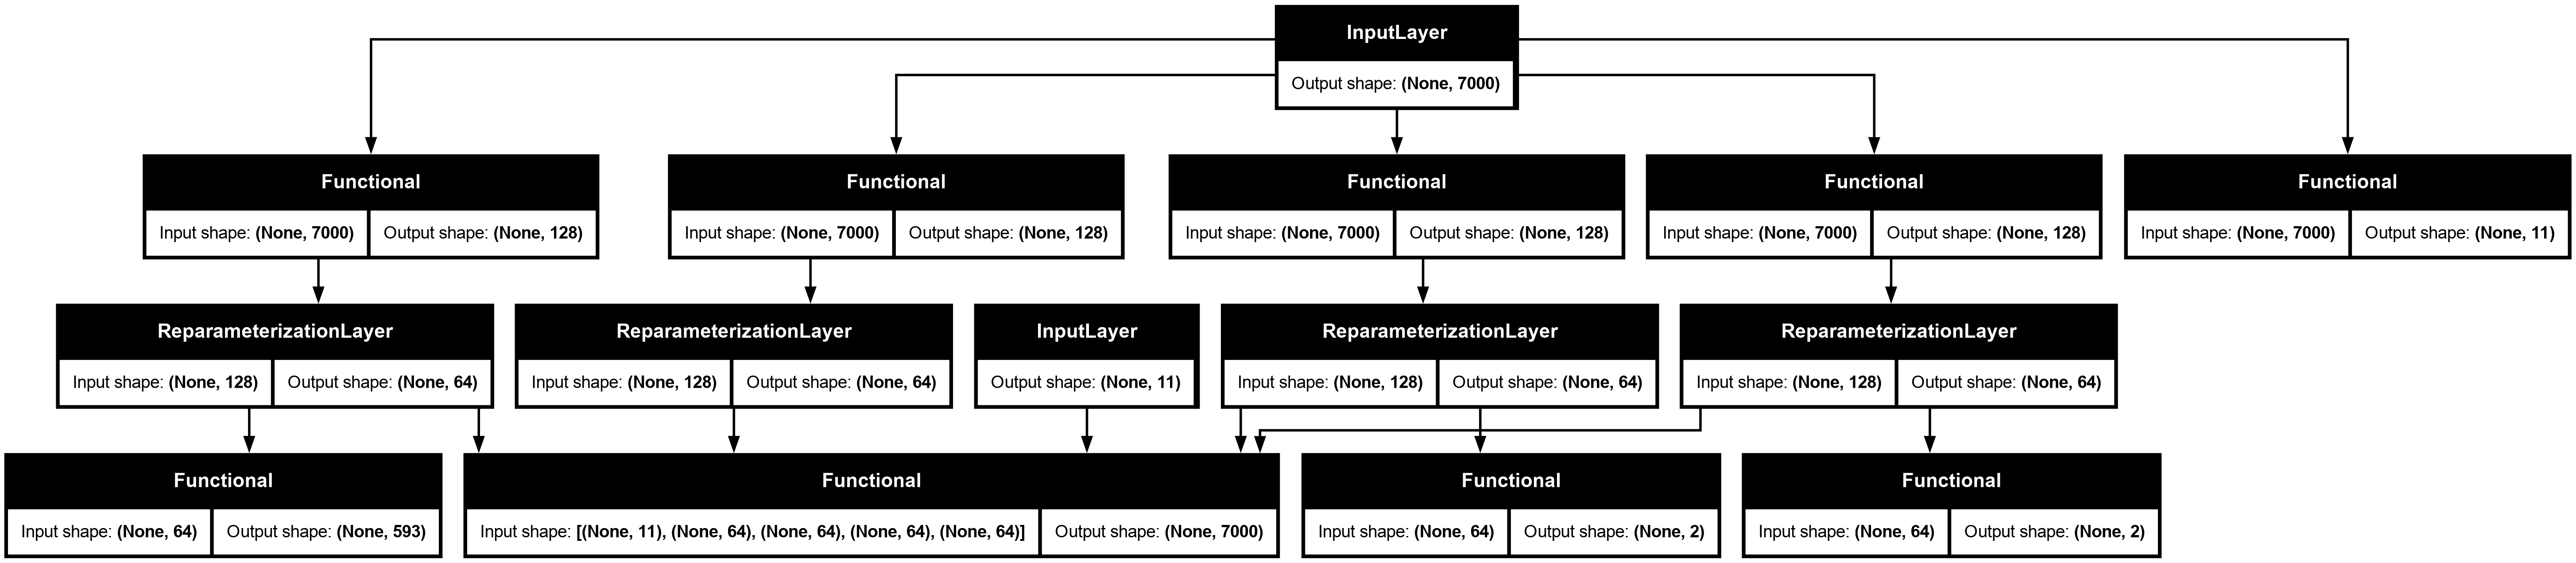

In [13]:
plot_model(obj.sup_model, show_shapes=True)

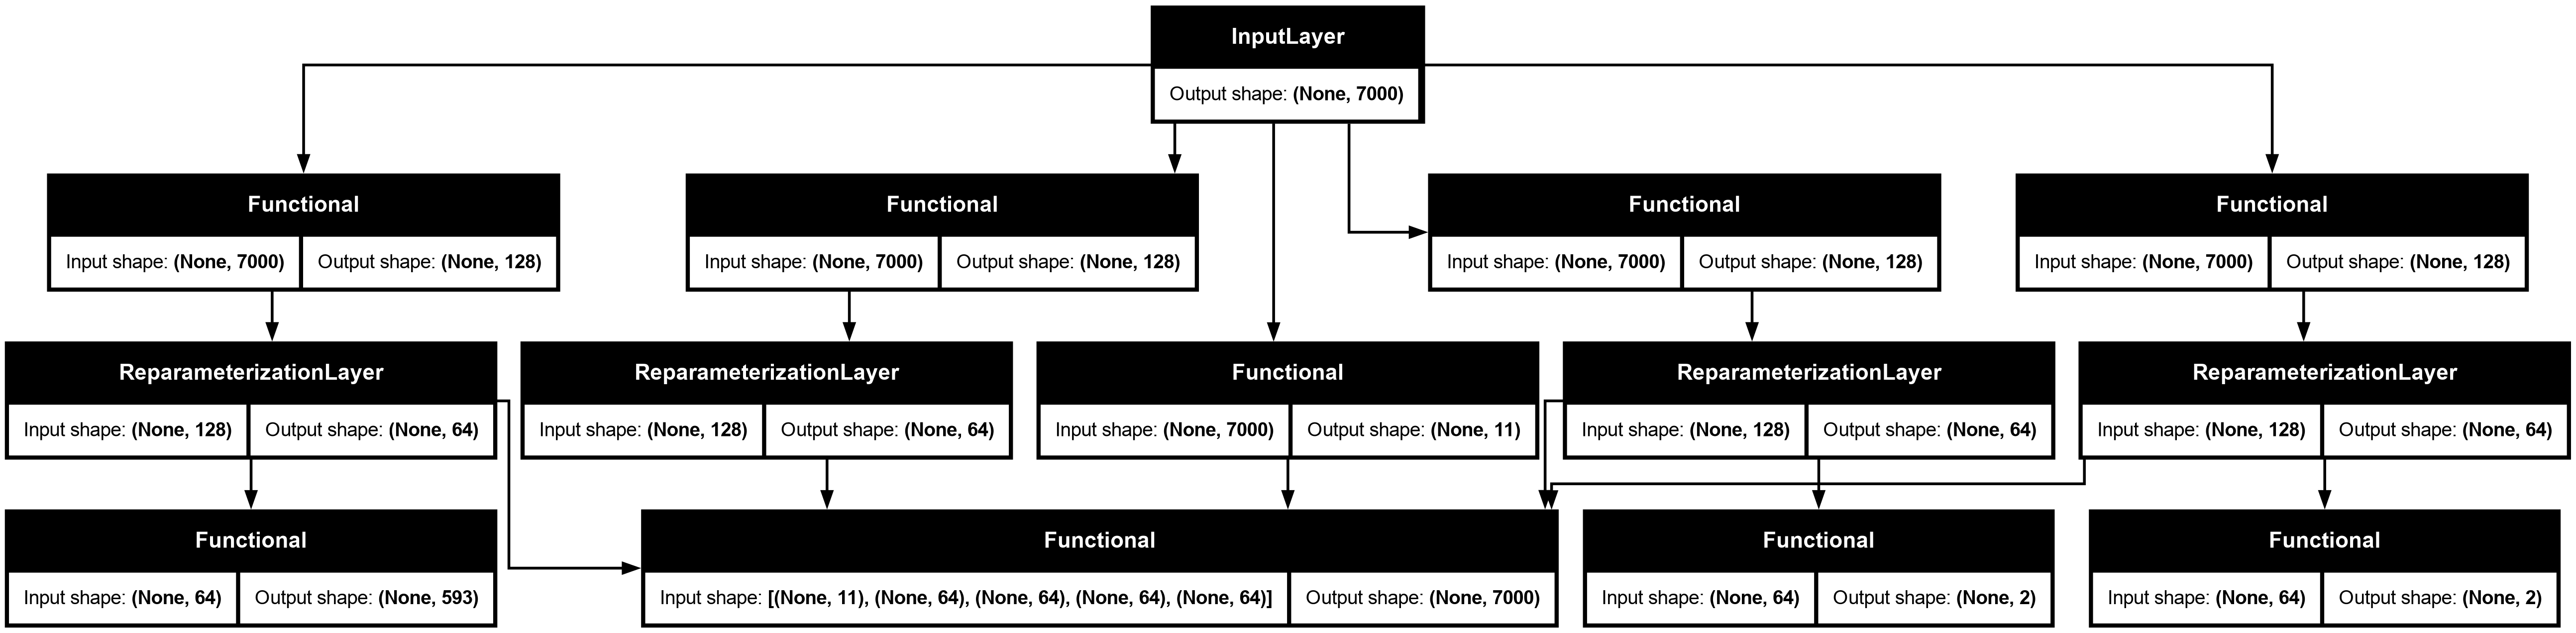

In [14]:
plot_model(obj.unsup_model, show_shapes=True)

In [15]:
!rm -f model.png

In [16]:
all_loss_df = fit_buddi4(
    obj.sup_model, obj.unsup_model, 
    ds_sup, ds_unsup, 
    epochs=10, batch_size=16, prefetch=True
)`                                                                                      `

Epoch 1/10:   0%|          | 0/525 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746136012.924183 1555183 service.cc:152] XLA service 0x59e3bf352920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746136012.924195 1555183 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-05-01 15:46:52.974203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746136013.322799 1555183 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746136015.051040 1555183 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Epoch 10/10: 100%|██████████| 525/525 [03:03<00:00,  2.86it/s]

Training complete!


/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


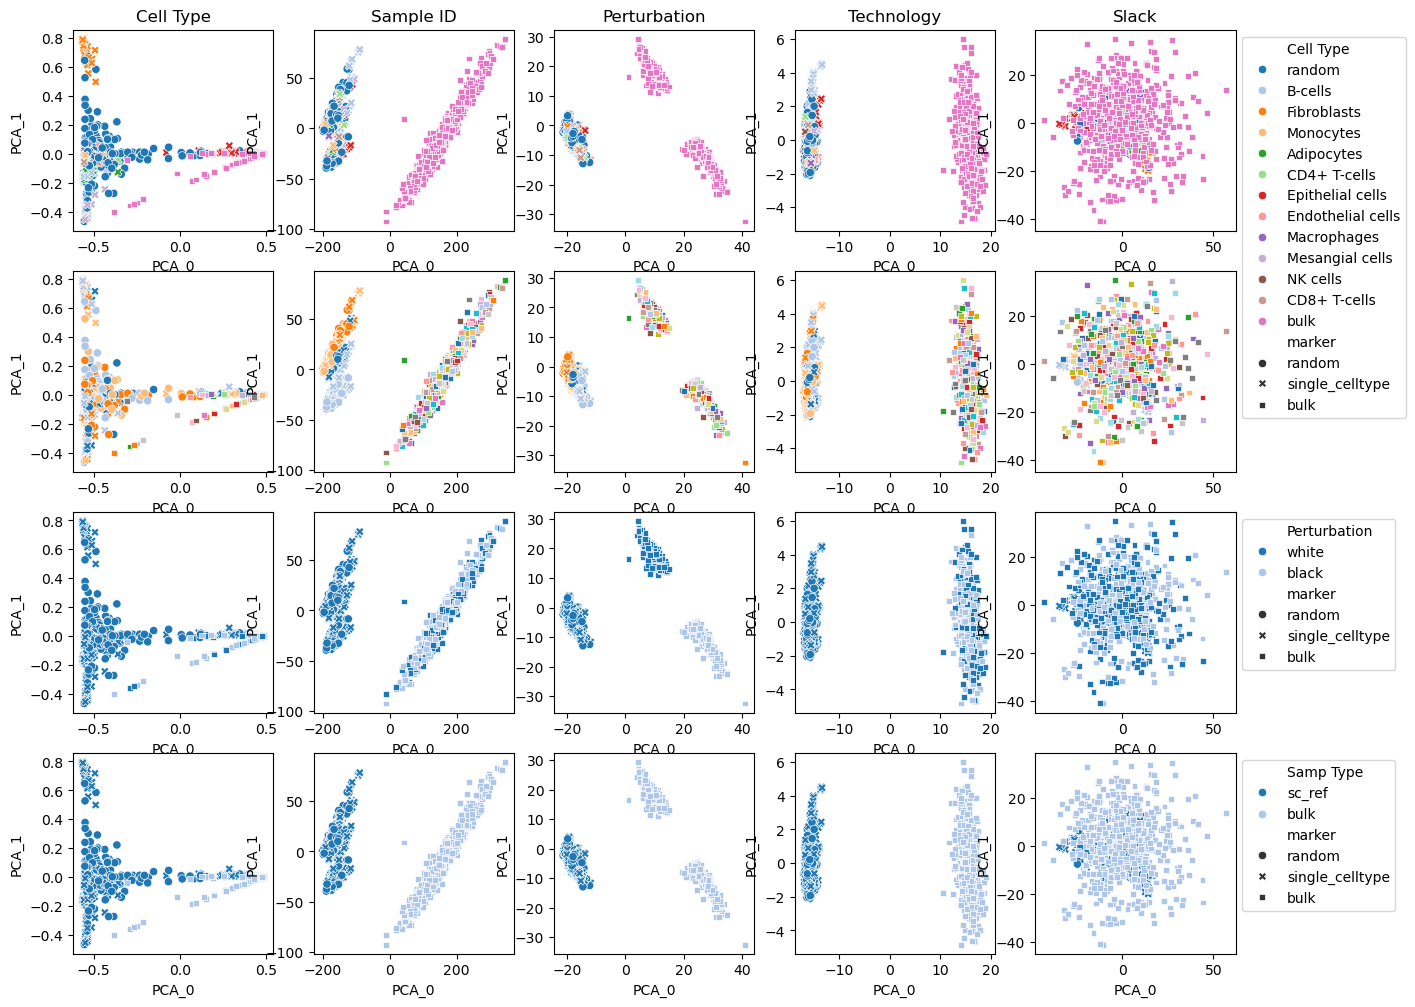

In [21]:
# # get the training pseudobulks
# idx_tmp_bulk = np.where(np.logical_and(
#     meta_concat.isTraining == "Train", 
#     meta_concat.samp_type == "sc_ref"))[0]
# idx_tmp_bulk = np.random.choice(idx_tmp_bulk, 500, replace=True)

# # get the real bulks
# idx_tmp = np.where(np.logical_and(
#     meta_concat.isTraining == "Train", meta_concat.samp_type == "bulk"))[0]
# idx_tmp = np.random.choice(idx_tmp, 500, replace=True)

# concatenate so we have them all
# idx_tmp = np.concatenate((idx_tmp, idx_tmp_bulk))

x_bulk = train_data.get(condition='unkp', key='X')
_idx_bulk = np.random.choice(x_bulk.shape[0], size=500, replace=False)
x_bulk_downsample = x_bulk[_idx_bulk, :]
x_sc_ref = train_data.get(condition='kp', key='X')
_idx_sc = np.random.choice(x_sc_ref.shape[0], size=500, replace=False)
x_sc_ref_downsample = x_sc_ref[_idx_sc, :]

X_tmp = np.concatenate((x_sc_ref_downsample, x_bulk_downsample), axis=0)
meta_tmp = pd.concat(
    [
        train_data.get(condition='kp', key='meta').iloc[_idx_sc, :],
        train_data.get(condition='unkp', key='meta').iloc[_idx_bulk, :],
    ],
    axis=0,
)

cell_types = train_data.cell_type_names
Y_tmp = np.concatenate(
    (
        train_data.get(condition='kp', key='Y')[_idx_sc, :],
        train_data.get(condition='unkp', key='Y')[_idx_bulk, :],
    ),
    axis=0,
)
idx_sc_prop = np.where(meta_tmp.cell_prop_type == "single_celltype")[0]
cell_type_labels = [cell_types[i] for i in np.argmax(Y_tmp[idx_sc_prop, :], axis=1)]
cell_type_col = meta_tmp.loc[:,'cell_prop_type'].values.copy()
cell_type_col[idx_sc_prop] = cell_type_labels
meta_tmp.loc[:,'cell_type'] = cell_type_col

_ = plot_latent_spaces_buddi4(
    obj.unsup_model,
    X_tmp,
    meta_tmp,
    type='PCA',
    alpha=1,    
    panel_width=3,
    show_plot=True,
    save_path=None,
    palette="tab20",
)

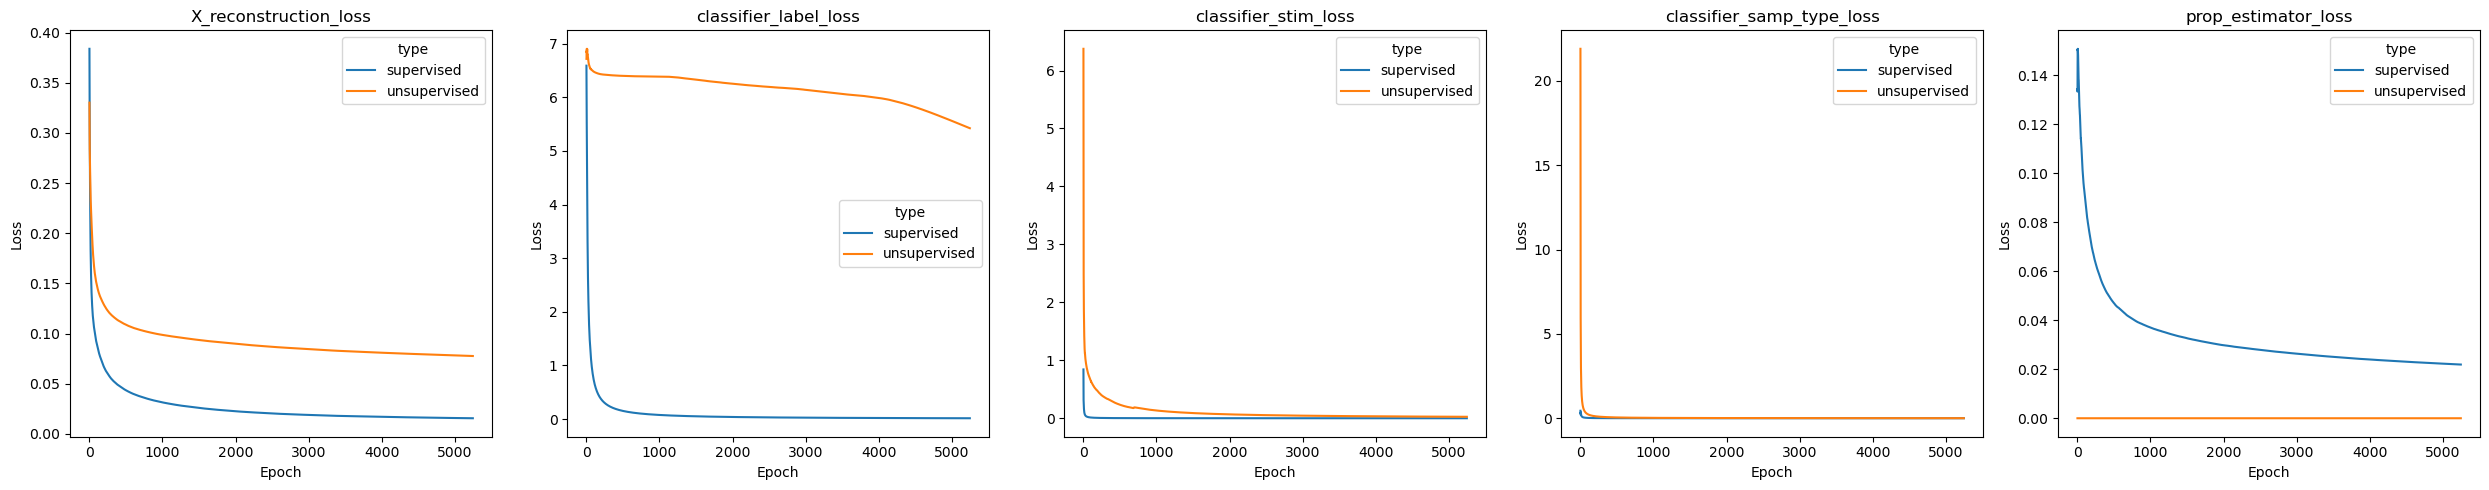

In [22]:
def simple_plot_loss(loss_df, show_plot=True, save_path=None):
    _, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)

    loss_columns = [
        'X_reconstruction_loss', 
        'classifier_label_loss', 
        'classifier_stim_loss', 
        'classifier_samp_type_loss', 
        'prop_estimator_loss'
    ]

    for ax, col in zip(axes, loss_columns):
        sns.lineplot(
            data=loss_df, 
            x='index', 
            y=col, 
            hue='type', 
            ax=ax
        )
        ax.set_title(col)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show_plot:
        plt.show()
    else:
        plt.close()

all_loss_df['index'] = all_loss_df.index.to_list()
simple_plot_loss(all_loss_df, save_path=None, show_plot=True)

In [ ]:
obj.save(
    TRAINED_MODELS_PATH / f'buddi4_alpha={CLS_ALPHA}_beta={BETA}'
)
loss_config = {
    'reconstruction_loss': RECONST_ALPHA,
    'classifier_label_loss': CLS_ALPHA,
    'classifier_stim_loss': CLS_ALPHA,
    'classifier_samp_type_loss': CLS_ALPHA,
    'prop_estimator_loss': Y_ALPHA,
    'beta': BETA,
    'beta_slack': BETA_SLACK
}
with open(
    TRAINED_MODELS_PATH / f'buddi4_alpha={CLS_ALPHA}_beta={BETA}' / 'loss_config.yml', 
    'w'
) as file:
    yaml.dump(loss_config, file)